In [1]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [2]:
# read data cloud
df = pd.read_csv('sonos_all_data-6m\sonoff_magnetron_dump_2019-08-01-2020-06-08.csv')
# convert epoch time to datetime

df['time'] = pd.to_datetime(df['time']/1000000000,unit='s')
df.head(10)

,name,time,mean_power,mean_current,mean_voltage
0,mqtt_consumer,2019-08-01 00:00:00,NaN,NaN,NaN
1,mqtt_consumer,2019-08-01 00:00:10,NaN,NaN,NaN
2,mqtt_consumer,2019-08-01 00:00:20,NaN,NaN,NaN
3,mqtt_consumer,2019-08-01 00:00:30,NaN,NaN,NaN
4,mqtt_consumer,2019-08-01 00:00:40,NaN,NaN,NaN
5,mqtt_consumer,2019-08-01 00:00:50,NaN,NaN,NaN
6,mqtt_consumer,2019-08-01 00:01:00,NaN,NaN,NaN
7,mqtt_consumer,2019-08-01 00:01:10,NaN,NaN,NaN
8,mqtt_consumer,2019-08-01 00:01:20,NaN,NaN,NaN
9,mqtt_consumer,2019-08-01 00:01:30,NaN,NaN,NaN


In [3]:
df=df.set_index(df['time'])['2019-12-23 00:00:00' :'2020-06-07 23:59:50']
df=df[['time','mean_power']]
df.head()

,time,mean_power
time,,
2019-12-23 00:00:00,2019-12-23 00:00:00,0.0
2019-12-23 00:00:10,2019-12-23 00:00:10,0.0
2019-12-23 00:00:20,2019-12-23 00:00:20,0.0
2019-12-23 00:00:30,2019-12-23 00:00:30,0.0
2019-12-23 00:00:40,2019-12-23 00:00:40,0.0


In [4]:
# prepare data 
df['time'] = pd.to_datetime(df['time'])
df['weekofyear']=df['time'].dt.week
df['day_name']=df['time'].dt.weekday
df['hour']=df['time'].dt.hour
df['mins']=df['time'].dt.minute

# prepare weekday, weekend, and holiday columns
df['day_type'] = df['day_name'].apply(lambda x: 'weekday' if x <5 else 'weekend')



df['weekofyear']=df['weekofyear'].apply(lambda x:-2 if x==51 else (-1 if x==52 else x) )
df['kWh']=df['mean_power']/1000*1/60*1/60*10
# lockdown
df.loc[df.weekofyear >12, 'day_type'] = 'holiday'
# christmas eve
df.loc[(df.weekofyear== -1) & (df.day_name==1 ) ,'day_type']='holiday'
# christmas
df.loc[(df.weekofyear== -1) & (df.day_name==2 ) ,'day_type']='holiday'
# new year
df.loc[(df.weekofyear== 1) & (df.day_name==2 ) ,'day_type']='holiday'

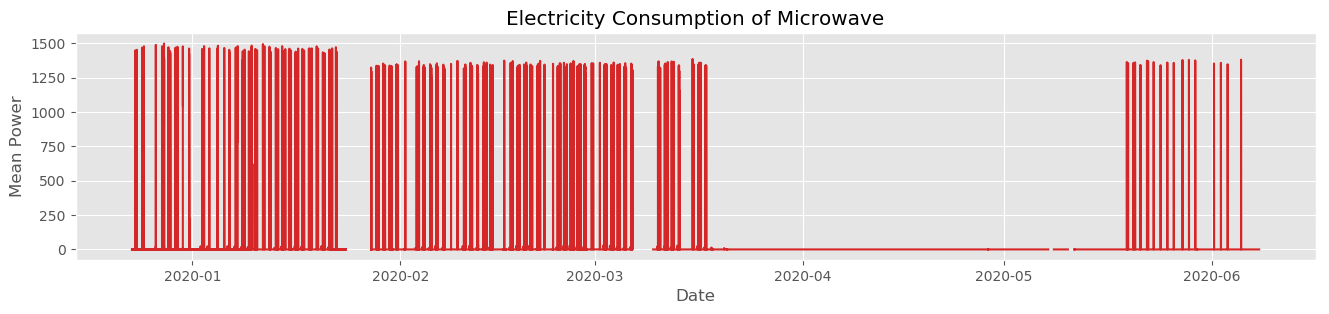

In [5]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Mean Power', dpi=100):
    plt.figure(figsize=(16,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df['time'], y=df['mean_power'], title='Electricity Consumption of Microwave')

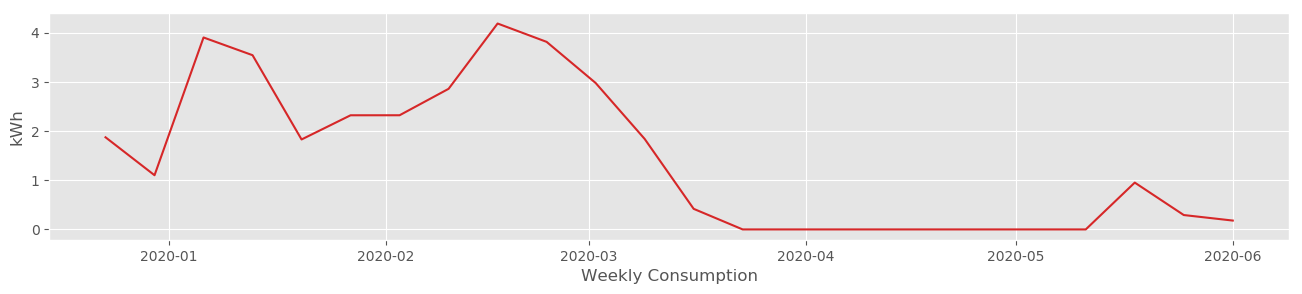

In [6]:
# prepare summed weekly, daily, and hourly patterns
week = pd.DataFrame({'Week_kWh' : (df.groupby( ['weekofyear'])['kWh'].sum())}).reset_index()
# the date is made here by using date_range
week['week_date'] = pd.date_range(start="12/17/2019", end="06/07/2020", freq='W-MON')
plot_df(week, x=week.week_date, y=week.Week_kWh, xlabel='Weekly Consumption',ylabel='kWh', title='') 

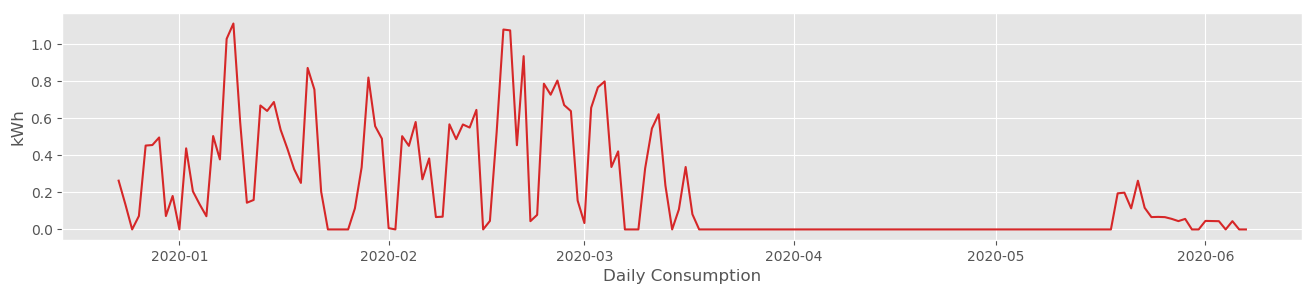

In [7]:
# prepare summed weekly, daily, and hourly patterns
day = pd.DataFrame({'day_kWh' : (df.groupby( ['weekofyear','day_name'])['kWh'].sum())}).reset_index()
day['day_date'] = pd.date_range(start="12/23/2019", end="06/07/2020", freq='D')
plot_df(day, x=day.day_date, y=day.day_kWh, xlabel='Daily Consumption',ylabel='kWh', title='') 

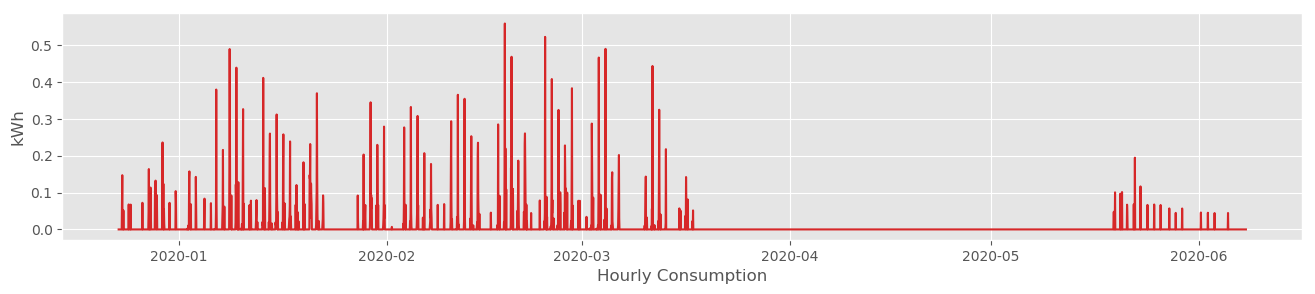

In [8]:
# prepare summed weekly, daily, and hourly patterns
hour = pd.DataFrame({'hour_kWh' : (df.groupby( ['weekofyear','day_name','hour'])['kWh'].sum())}).reset_index()
hour['hour_index'] = pd.date_range(start="12/23/2019", end="06/07/2020 23:00:00", freq='H')
plot_df(hour, x=hour.hour_index, y=hour.hour_kWh, xlabel='Hourly Consumption',ylabel='kWh', title='') 

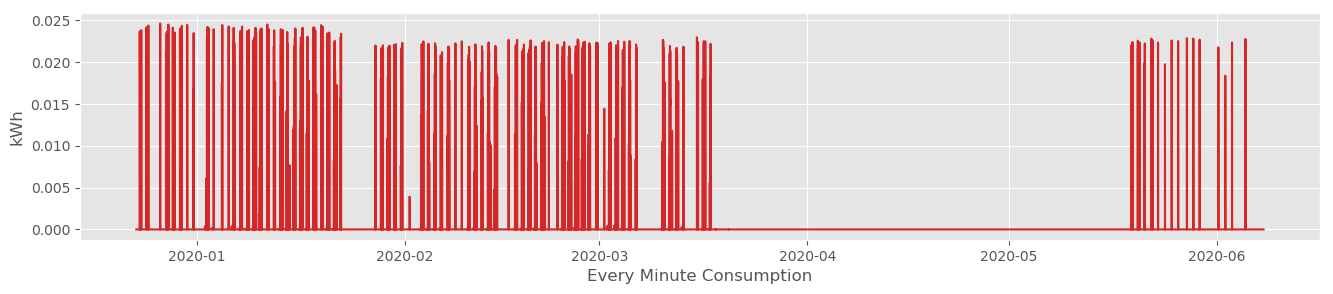

In [9]:
# prepare summed weekly, daily, and hourly patterns
minute = pd.DataFrame({'minute_kWh' : (df.groupby( ['weekofyear','day_name','hour','mins'])['kWh'].sum())}).reset_index()
minute['mins_index'] = pd.date_range(start="12/23/2019", end="06/07/2020 23:59:00", freq='T')
plot_df(minute, x=minute.mins_index, y=minute.minute_kWh, xlabel='Every Minute Consumption',ylabel='kWh', title='') 

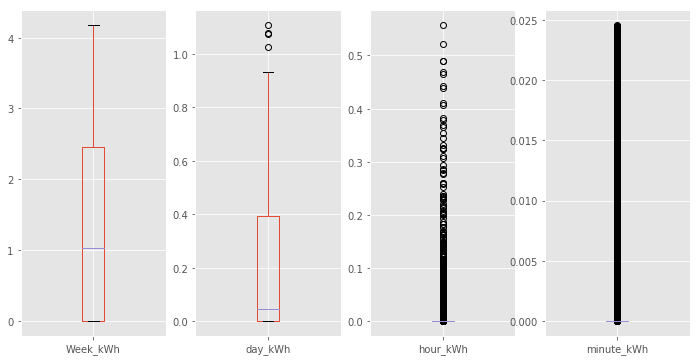

In [10]:
# boxplots of power consumption 
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
weekbp = week.boxplot(column=['Week_kWh'])

plt.subplot(1, 4, 2)
daybp = day.boxplot(column=['day_kWh'])

plt.subplot(1, 4, 3)
hourbp = hour.boxplot(column=['hour_kWh'])

plt.subplot(1, 4, 4)
minsbp = minute.boxplot(column=['minute_kWh'])

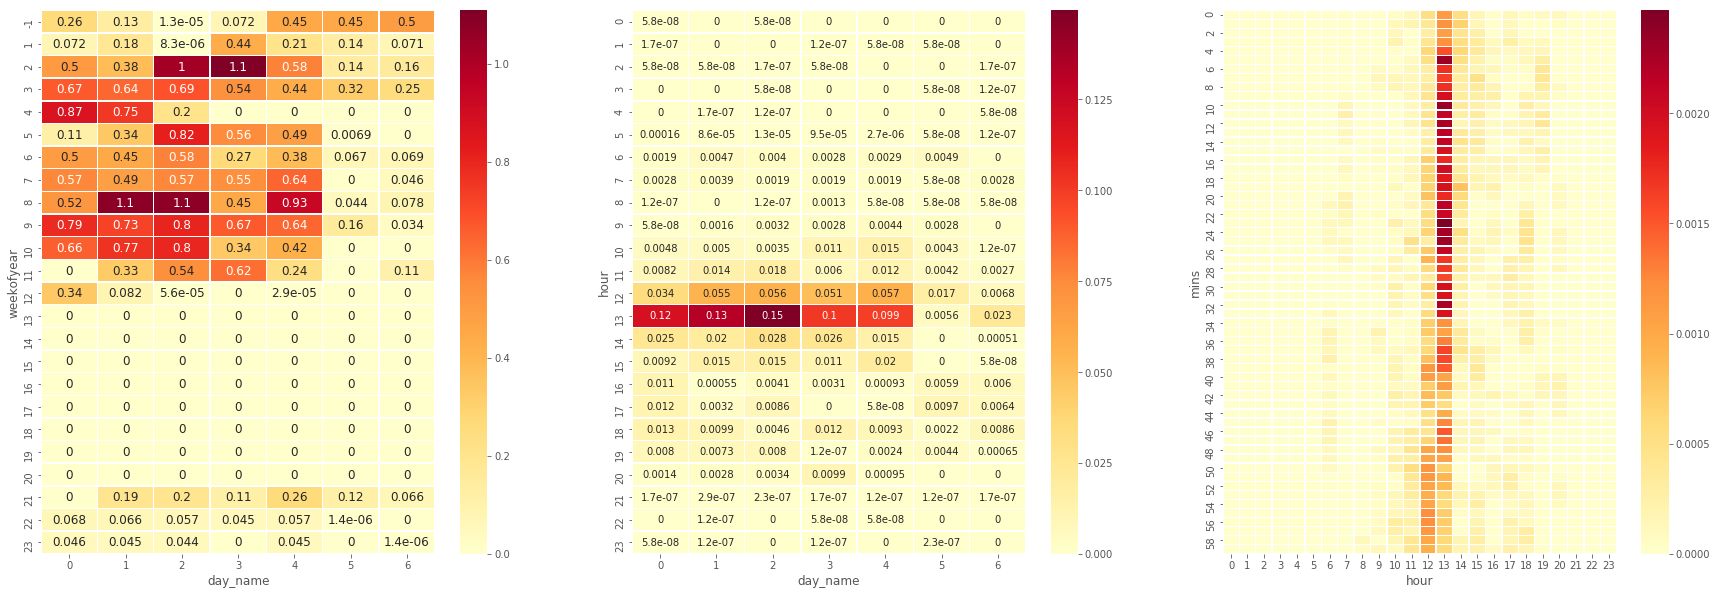

In [11]:
# heatmap of different period time trend

fig = plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
# plot week and day heatmap  
day_pi = day.pivot("weekofyear", "day_name", "day_kWh")
ax0 = sns.heatmap(day_pi, linewidth=0.5, annot=True,cmap="YlOrRd",annot_kws={"size": 12})

plt.subplot(1, 3, 2)
# plot day and hour heatmap  
hour_pi =hour.reset_index().pivot_table("hour_kWh", "hour","day_name" )
ax1 = sns.heatmap(hour_pi,linewidth=0.5 ,cmap="YlOrRd",annot=True,annot_kws={"size": 10})

plt.subplot(1, 3, 3)
# plot hour and minute heatmap
mins_pi =minute.reset_index().pivot_table( "minute_kWh", "mins","hour")
ax2 = sns.heatmap(mins_pi,linewidth=0.5 ,cmap="YlOrRd",annot=False,annot_kws={"size": 8})

In [12]:
df['kWh'].fillna(method='ffill',limit=478, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1451520 entries, 2019-12-23 00:00:00 to 2020-06-07 23:59:50
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   time        1451520 non-null  datetime64[ns]
 1   mean_power  1372402 non-null  float64       
 2   weekofyear  1451520 non-null  int64         
 3   day_name    1451520 non-null  int64         
 4   hour        1451520 non-null  int64         
 5   mins        1451520 non-null  int64         
 6   day_type    1451520 non-null  object        
 7   kWh         1377066 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 99.7+ MB


In [14]:
# assum missing value would be as normal pattern before lockdown, so replace the value same as the week before 
import math
for i in range(0,725760):
    if math.isnan(float(df['kWh'][i])):
        df['kWh'][i]= df['kWh'][i-60480]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
# assum missing value would be as normal pattern after lockdown, so replace the value same as the week before 
for i in range(725760,len(df)):
    if math.isnan(float(df['kWh'][i])):
        df['kWh'][i]= df['kWh'][i+60480]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1451520 entries, 2019-12-23 00:00:00 to 2020-06-07 23:59:50
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   time        1451520 non-null  datetime64[ns]
 1   mean_power  1372402 non-null  float64       
 2   weekofyear  1451520 non-null  int64         
 3   day_name    1451520 non-null  int64         
 4   hour        1451520 non-null  int64         
 5   mins        1451520 non-null  int64         
 6   day_type    1451520 non-null  object        
 7   kWh         1451520 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 99.7+ MB


In [17]:
df1=df[['mean_power','weekofyear','day_name','hour','mins','day_type','kWh']]
# using sqlite as the database 
from sqlalchemy import create_engine
engine = create_engine('sqlite:///dissertation.db', echo=True) #set the database name as jba.db
sqlite_connection = engine.connect()
sqlite_table = "microwave"       #set the table name as rainfall_data
df1.to_sql(sqlite_table, sqlite_connection, if_exists='replace')  # import dataframe to sqlite

2020-08-02 12:19:26,269 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-08-02 12:19:26,269 INFO sqlalchemy.engine.base.Engine ()
2020-08-02 12:19:26,269 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-08-02 12:19:26,280 INFO sqlalchemy.engine.base.Engine ()
2020-08-02 12:19:26,370 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("microwave")
2020-08-02 12:19:26,370 INFO sqlalchemy.engine.base.Engine ()
2020-08-02 12:19:26,386 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("microwave")
2020-08-02 12:19:26,386 INFO sqlalchemy.engine.base.Engine ()
2020-08-02 12:19:26,394 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2020-08-02 12:19:26,394 INFO sqlalchemy.engine.base.Engine ()
2020-08-02 12:19:26,398 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("microwave")
2020-08-02 12:19:26,402 INFO sqlalchemy.engine.base.Engine 

In [80]:
sqlite_connection.close() # close the connection

In [76]:
df_engineering= df.copy()

In [ ]:
df_engineering

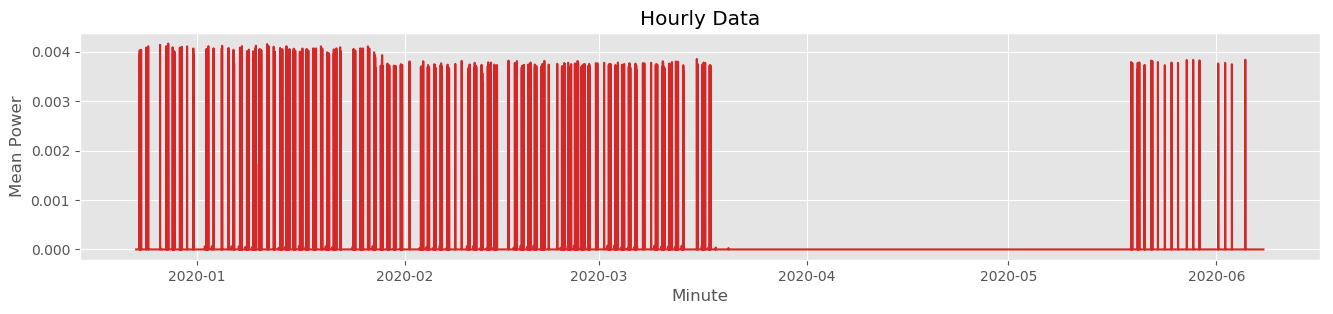

In [70]:
plot_df(df, x=df.time, y=df.kWh, xlabel='Minute',ylabel='Mean Power', title='Hourly Data') 

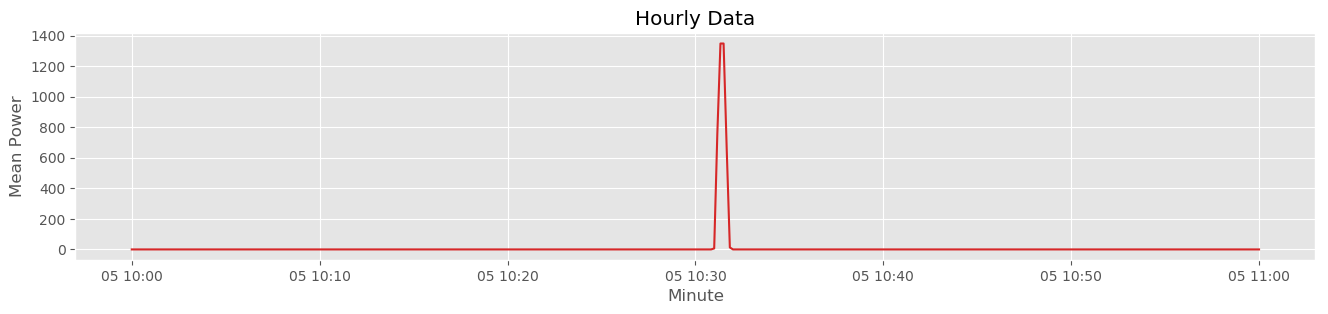

In [6]:
hourly_df = df.set_index(df['time'])['2020-02-05 10:00:00' :'2020-02-05 11:00:00']
plot_df(hourly_df, x=hourly_df.time, y=hourly_df.mean_power, xlabel='Minute',ylabel='Mean Power', title='Hourly Data') 

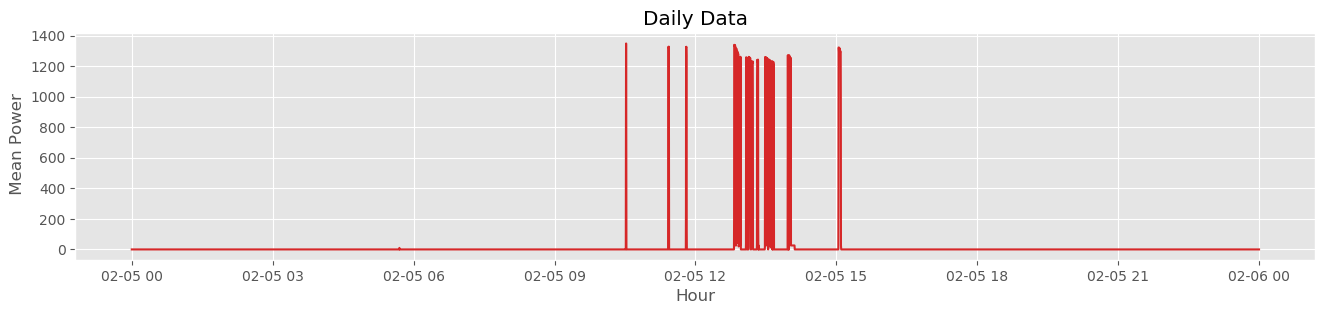

In [7]:
daily_df=df.set_index(df['time'])['2020-02-05 00:00:00' :'2020-02-05 23:59:50']

plot_df(daily_df, x=daily_df.time, y=daily_df.mean_power, xlabel='Hour',ylabel=' Mean Power', title='Daily Data') 

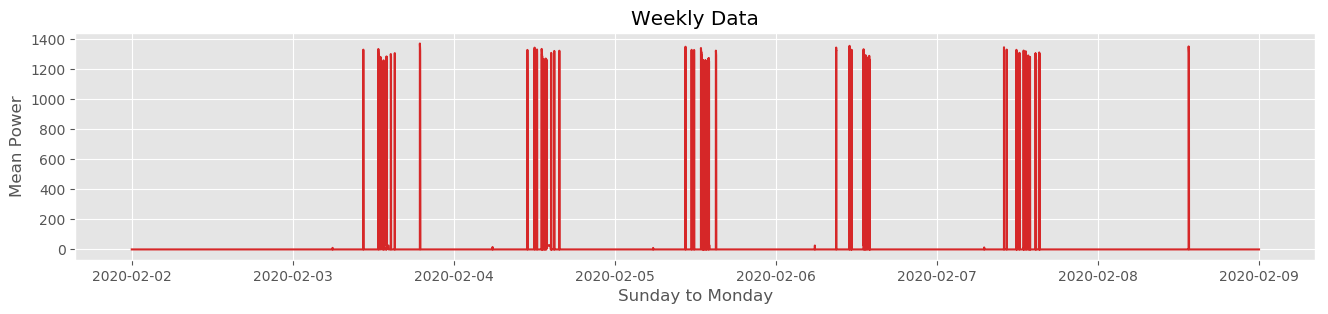

In [8]:
weekly_df=df.set_index(df['time'])['2020-02-02 00:00:00' :'2020-02-08 23:59:50']

plot_df(weekly_df, x=weekly_df.time, y=weekly_df.mean_power, xlabel='Sunday to Monday',ylabel='Mean Power', title='Weekly Data')

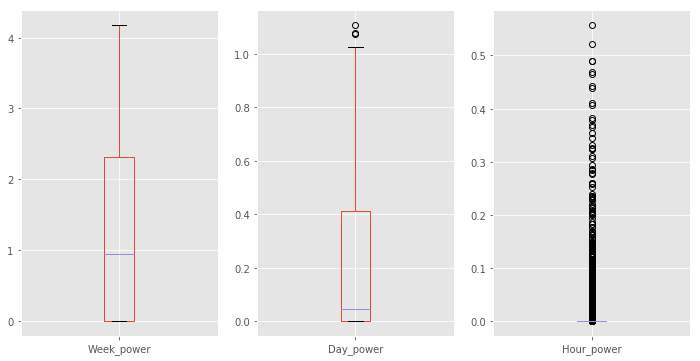

In [10]:
# boxplots of power consumption 
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
week = pd.DataFrame({'Week_power' : (df.groupby( ['weekofyear'])['mean_power'].sum()/1000*1/60*1/60*10)}).reset_index()

weekbp = week.boxplot(column=['Week_power'])

plt.subplot(1, 3, 2)
day = pd.DataFrame({'Day_power' : (df.groupby( ['weekofyear','day_name'])['mean_power'].sum()/1000*1/60*1/60*10)}).reset_index()
daybp = day.boxplot(column=['Day_power'])

plt.subplot(1, 3, 3)
hour = pd.DataFrame({'Hour_power' : (df.groupby( ['weekofyear','day_name','Hour'] )['mean_power'].sum()/1000*1/60*1/60*10)}).reset_index()
hourbp = hour.boxplot(column=['Hour_power'])